---
title: "Case Study: Pfizer (PFE) Trading Strategy Report"
author: "Edoardo Luciani"
date: "2025-11-22"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\newpage# 

In [7]:
#| warning: false
library(dplyr)
library(dtplyr)
library(data.table)
library(lubridate)
library(magrittr)
library(quantmod)
library(PerformanceAnalytics)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                 

# Dataset analysis and preprocessing

I load the large Compustat dataset using `fread()`, selecting only the relevant columns (tic, datadate, prccd) to optimize memory and performance.

In [8]:
big_data_start <- fread("compustat_daily_2010_2025.csv",
select = c("tic", "datadate", "prccd"))
glimpse(big_data_start)

Rows: 783,992
Columns: 3
$ tic      <chr> "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR"…
$ datadate <chr> "01/04/2010", "01/05/2010", "01/06/2010", "01/07/2010", "01/0…
$ prccd    <dbl> 23.77, 24.23, 25.45, 25.85, 25.44, 25.15, 24.75, 24.57, 24.93…


I extract Pfizer (PFE) data from the full dataset, convert the datadate field to a proper Date format, and sort the observations in ascending order. Finally, I display the first ten rows to verify the data structure.

In [9]:
pfe_data <-  big_data_start[
  tic == "PFE",
  .(datadate = as.Date(datadate, "%m/%d/%Y"), prccd)
][order(datadate)]
head(pfe_data, 10)

datadate,prccd
<date>,<dbl>
2010-01-04,18.93
2010-01-05,18.66
2010-01-06,18.60
2010-01-07,18.53
2010-01-08,18.68
2010-01-11,18.83
2010-01-12,18.77
2010-01-13,19.21
2010-01-14,19.38


I compute simple daily returns using the percentage price-change formula, defined as
$$ return_{t} = {(close_t - close_{t-1}) \over close_{t-1}} $$
This is implemented via `mutate()` and `lag()`, which align each closing price with its previous value. I then summarize the return series and compute the standard deviation to obtain a concise statistical overview.

In [4]:
pfe_data  <- pfe_data %>% 
  mutate(daily_returns = (prccd/lag(prccd)) - 1) %>%
  na.omit()

summary(pfe_data$daily_returns)
sd(pfe_data$daily_returns, na.rm = TRUE)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.0773464 -0.0068156  0.0000000  0.0001602  0.0071491  0.1085519 

[1] 0.0139851

## Autocorrelation Analysis of Returns

I analyze the autocorrelation of Pfizer's returns using the `Acf()` function from the forecast package.This function computes and plots the autocorrelation function (ACF) for the return series, allowing me to visually inspect any significant correlations at different lags.

### Daily Returns Autocorrelation Results

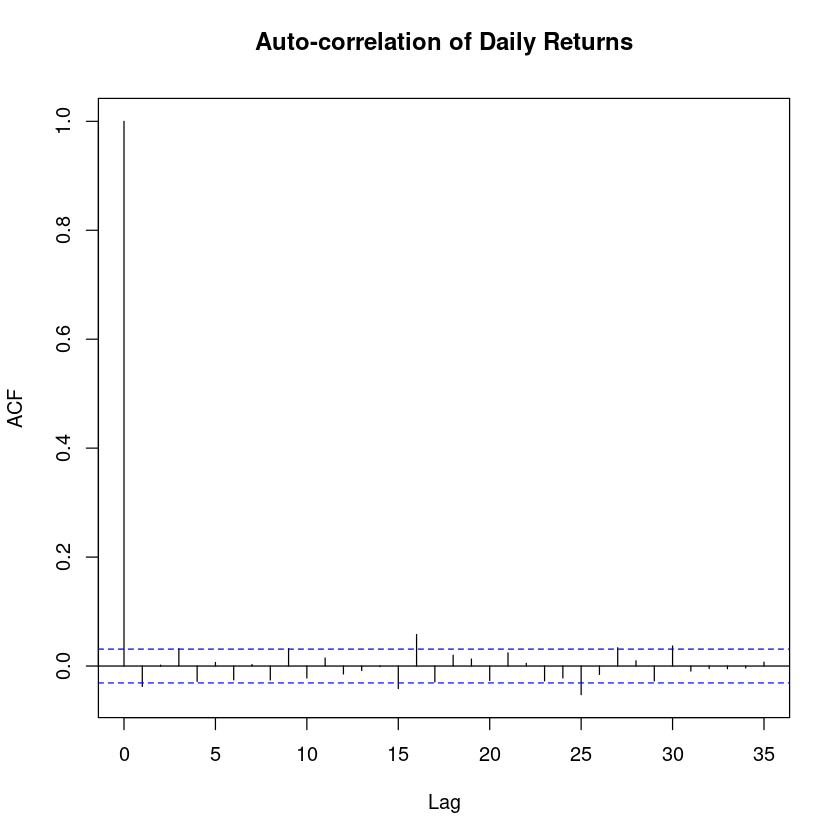

In [ ]:
#| fig-cap: "Auto-correlation of Daily Results"
acf(pfe_data$daily_returns, main= "Auto-correlation of Daily Returns")

In [100]:
acf(pfe_data$daily_returns, plot = FALSE) %>%
  {.$acf} %>%
  as.numeric() %>%
  .[-1] %>%
  abs() %>%
  max() %>%
  round(4) %>%
  paste0("Maximum auto-correlation magnitude is ", .)

[1] "Maximum auto-correlation magnitude is 0.0578"

As a result, the maximum autocorrelation magnitude is well below the 0.2 threshold, indicating minimal serial dependence in daily returns, consisntent with the weak form of market efficiency.

### Weekly Returns Autocorrelation Results

I transform daily returns into weekly mean returns by grouping observations at the weekly frequency, and then evaluate serial dependence by plotting the autocorrelation function of the aggregated weekly returns.

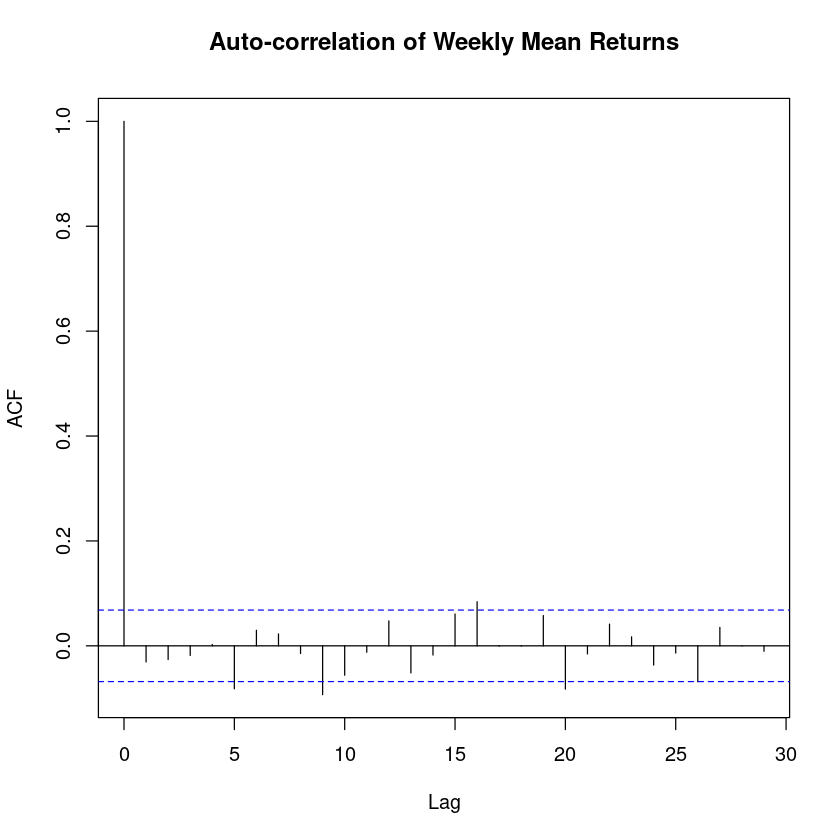

In [ ]:
#| fig-cap: "Auto-correlation of Weekly Results"
weekly_data <- pfe_data %>%
  mutate(week = floor_date(datadate, "week")) %>%
  group_by(week) %>%
  summarise(weekly_returns = mean(daily_returns ))

acf(weekly_data$weekly_returns,
  main = "Auto-correlation of Weekly Mean Returns")


In [102]:
acf(weekly_data$weekly_returns, plot = FALSE) %>%
  {.$acf} %>%
  as.numeric() %>%
  .[-1] %>%
  abs() %>%
  max() %>%
  round(4) %>%
  paste0("Maximum auto-correlation magnitude is ", .)

[1] "Maximum auto-correlation magnitude is 0.0931"

As we observed for daily returns, the maximum autocorrelation magnitude for weekly returns is also low, further supporting the conclusion of weak serial dependence in Pfizer's stock returns over both daily and weekly horizons.      

## Defining the Time Window of Analysis

In [17]:
pfe_data <- pfe_data %>%
  filter(datadate >= as.Date("2020-01-01"))

# Triple Moving Average Strategy

`strategy_triple_MA()` implements a trading rule based on three simple moving averages of the closing price, with fixed windows of 7 (fast), 21 (mid) and 200 (slow) periods. The idea is to separate the identification of the background trend from the timing of the trades. 

First, the function classifies the trend regime using the medium- and long-term averages. When the 21-day MA is above the 200-day MA `(MA_mid > MA_slow)`, the market is labelled as a bull regime; when the 21-day MA is below the 200-day MA `(MA_mid < MA_slow)`, it is labelled as a bear regime. These regimes define the windows in which trading is allowed: in a bull regime the strategy operates long-only, while in a bear regime it operates short-only. 

Within each regime, the actual trading signal is generated by the crossover between the fast and the medium moving averages. A long entry occurs when the 7-day MA crosses above the 21-day MA inside a bull regime. Symmetrically, a short entry occurs when the 7-day MA crosses below the 21-day MA inside a bear regime. In this way the strategy first detects the prevailing trend with the slow pair (21–200) and then uses the fast–medium pair (7–21) to time entries and exits, providing a trend-following trading rule that is more robust to noise and whipsaws.

In [ ]:
source("triple_ma.R")

signals  <- triple_ma_strategy(pfe_data, 
                               price_col = "prccd",
                               fast_n  = 7,
                               mid_n   = 21,
                               slow_n  = 200)

## Backtesting Triple Moving Average Strategy & Performance Evaluation

In [ ]:
xts_prices  <- xts(signals$prccd, order.by = signals$datadate)
xts_signals <- xts(signals$position, order.by = signals$datadate)
bt <- backtest(xts_prices, xts_signals)

The strategy exhibits a markedly different behaviour compared to the benchmark over the full sample 2020–2025, clearly outperforming it in both return and risk management. The introduction of explicit bullish and bearish regimes significantly reduces potential drawdowns relative to the benchmark. This regime-based framework prevents the strategy from remaining exposed during prolonged market declines.

In the first part of the sample, the strategy closely tracks the benchmark during the upward phase. However, once the benchmark enters a pronounced downtrend, the strategy continues to generate alpha, reaching a performance peak in early 2024. From that point onward, the market transitions into a sideways environment with a bearish bias. Such lateralisation typically undermines trend-following systems, and this is reflected in the strategy’s reduced effectiveness in the latter part of the sample.

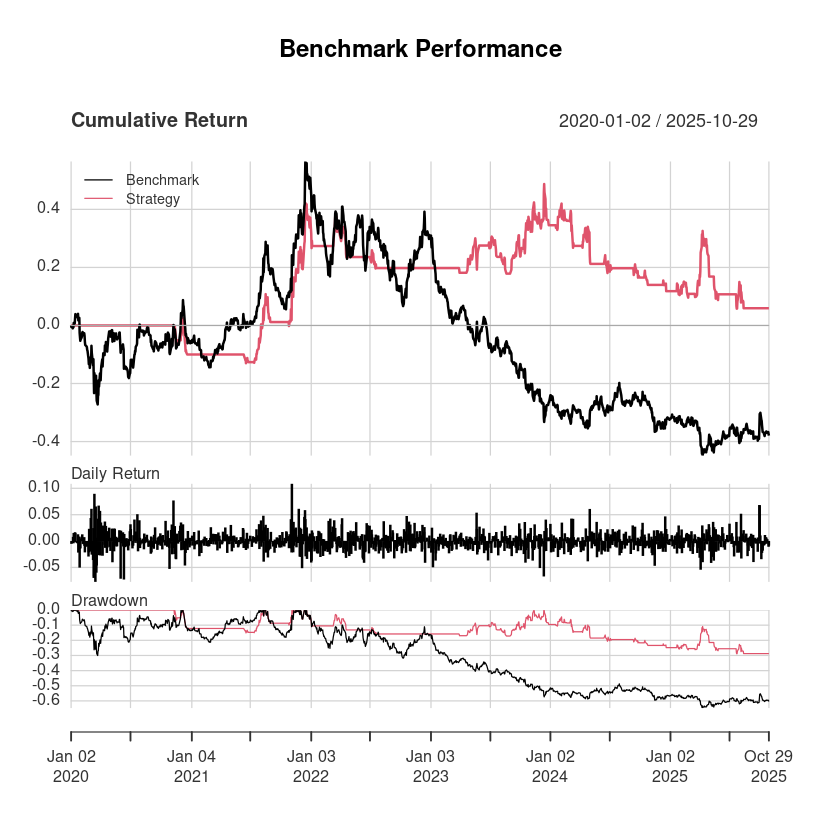

In [8]:
#| fig-cap: "Triple MA Strategy Backtesting"
charts.PerformanceSummary(bt)

The results are nonetheless decisive. While the benchmark experiences a drawdown exceeding –60%, the strategy remains consistently above water, ending the sample in the +6% to +7% range, with a maximum drawdown limited to roughly –30%. This represents higher returns with substantially better risk control, demonstrating the robustness of combining medium- and long-term trend filters with a fast execution signal. 

The next is to further optimize the strategy by tuning the moving average parameters.

## Optimizing Moving Average Parameters & Results 

To optimize the moving average parameters, I test a range of values for the fast, mid, and slow windows by implementing a loop function that iterates over all combinations of the specified parameter values.

In [ ]:
fast_candidates <- c(5, 7)
mid_candidates  <- c(13, 15, 17, 21)
slow_candidates <- c(200, 250, 300)

In [ ]:
# it's the starting point, I need as initial benchmark
best_perf  <- -Inf
best_f  <- NA
best_m  <- NA
best_s  <- NA

# for function for selecting each candidate of each category
for (f in fast_candidates) {
  for (m in mid_candidates) {
    for (s in slow_candidates) {

      # I plug the parameters into the strategy
      signals <- triple_ma_strategy(pfe_data,
        price_col = "prccd",    # nolint
        fast_n    = f,
        mid_n     = m,
        slow_n    = s)

      # Backtest process for each combination
      xts_prices  <- xts(signals$prccd, order.by = signals$datadate)
      xts_signals <- xts(signals$position, order.by = signals$datadate)
      bt <- backtest(xts_prices, xts_signals)

      # Calculated the performance for each pairs
      perf  <- prod(1 + bt$Strategy, na.rm = TRUE)

      # I compare the cumulative return with the previous best
      if (perf > best_perf) {
        best_perf <- perf
        best_f <- f  #final output
        best_m <- m  #final output
        best_s <- s  #final output
      }
    }
  }
}

In [ ]:
print(best_f)
print(best_m)
print(best_s)

[1] 5
[1] 13
[1] 300


## Optimized Parameters Results

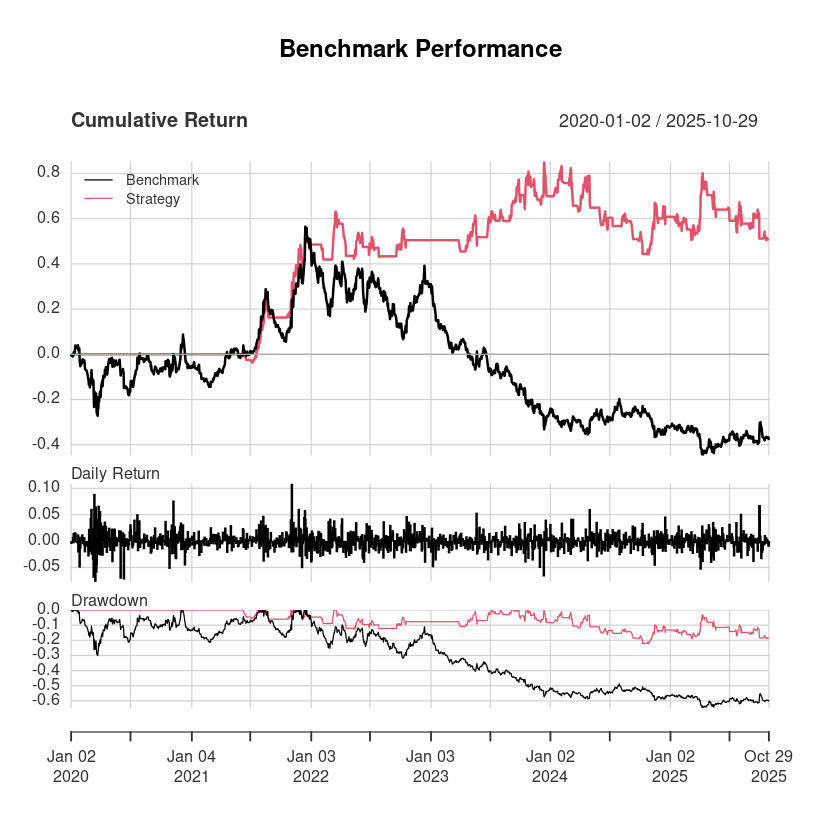

In [ ]:
#| fig-cap: "Triple MA Strategy Optimized Backtesting"
signals_opti  <- triple_ma_strategy(pfe_data,
                               price_col = "prccd",
                               fast_n  = best_f,
                               mid_n   = best_m,
                               slow_n  = best_s)

xts_prices  <- xts(signals_opti$prccd, order.by = signals_opti$datadate)
xts_signals <- xts(signals_opti$position, order.by = signals_opti$datadate)
bt <- backtest(xts_prices, xts_signals)

charts.PerformanceSummary(bt)

As we can observe, the optimized combination 5, 13, 300 offers superior performance compared to the initial fixed parameters of 7, 21, and 200, further highlighting the already robust nature of the triple moving average strategy, leading to a final cumulative return of approximately 45% and a maximum drawdown of around -20%.

Another potential enhancement to improve performance during the final, trendless period would be to incorporate additional filters—such as requiring a minimum slope for the 300-day SMA to confirm trend direction, or applying ATR-based thresholds to identify and avoid low-volatility, sideways market conditions. These additions could reduce whipsaws and further strengthen the strategy in non-trending environments.

### Line Plot of MAs with Price Chart

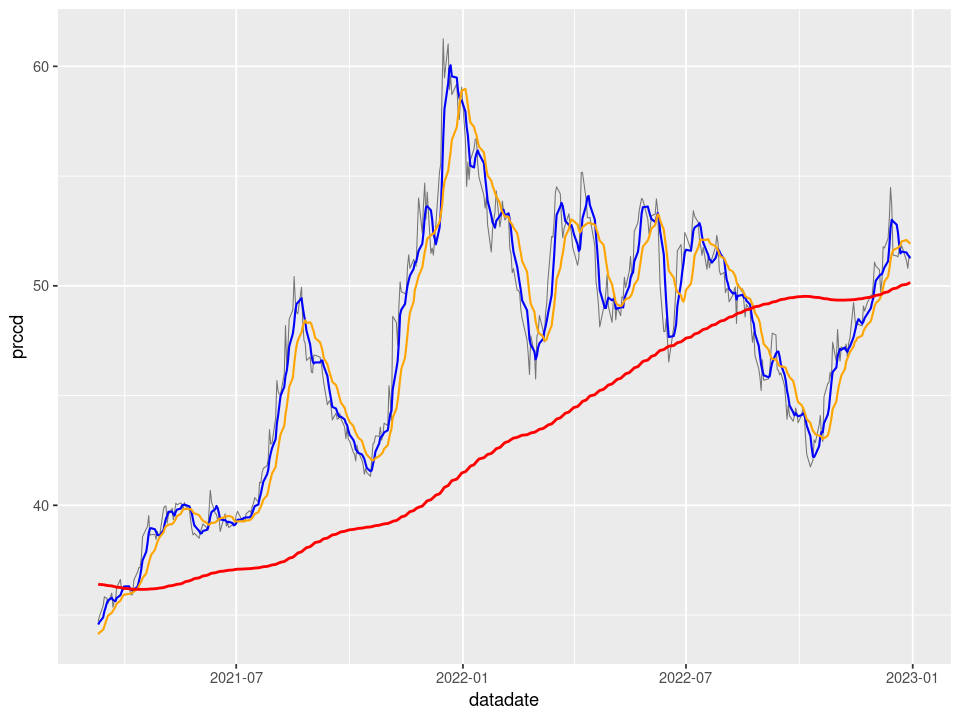

In [ ]:
#| fig-cap: "Line Plot of Triple MA Strategy"
signals_opti_clean <- signals_opti %>%
  filter(
    !is.na(MA_fast),
    !is.na(MA_mid),
    !is.na(MA_slow),
    datadate >= "2021-01-01",
    datadate <= "2023-01-01"
  )

options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(signals_opti_clean, aes(x = datadate)) +
  geom_line(aes(y = prccd), color = "black", linewidth = 0.3, alpha = 0.5) +
  geom_line(aes(y = MA_fast), color = "blue", linewidth = 0.6) +
  geom_line(aes(y = MA_mid), color = "orange", linewidth =  0.6) +
  geom_line(aes(y = MA_slow), color = "red", linewidth = 0.8)

# Bollinger Bands Breakout Strategy

The `bb_strategy()` function implements a trading strategy based on Bollinger Bands breakouts. The strategy is designed to distinguish between real breakouts and false signals by incorporating RSI confirmation and volatility filtering. Lastly the exit policy is based on a trailing stop mechanism based on RSI 50 level in order to lock in profits and limit losses.

In [18]:


bb_strategy <- function(data,
                        price_col = "prccd", 
                        bb_n = 20,          # bollinger bands period
                        k = 1.8,            # deviazione standard
                        rsi_n = 14,         # RSI period
                        rsi_long_thr = 53,  # RSI threshold for long
                        rsi_short_thr = 47, # RSI threshold for short
                        bbw_quantile = 0.33 # compression signal
                        ) {

  price <- data[[price_col]]

  data <- data %>%
    mutate(
      # Bollinger Bands su Close
      bb = BBands(price, n = bb_n, sd = k),
      mavg  = bb[, "mavg"],
      upper = bb[, "up"],
      lower = bb[, "dn"],

      # Bollinger Band Width
      bb_width = (upper - lower) / mavg,

      # Threshold 
      bbw_thr = quantile(bb_width, probs = bbw_quantile, na.rm = TRUE),

      # Compression Trigger
      vol_compression = bb_width < bbw_thr,

      # RSI filter for trend direction
      rsi = RSI(price, n = rsi_n),

      rsi_long_filter  = rsi > rsi_long_thr,
      rsi_short_filter = rsi < rsi_short_thr,

      # Breakout trigger
      long_breakout = price > upper,
      short_breakout = price < lower,

      # All conditions to entry the position
      long_entry_cond  = vol_compression & rsi_long_filter  & long_breakout,
      short_entry_cond = vol_compression & rsi_short_filter & short_breakout

    )

  n <- nrow(data)
  position <- numeric(n)
  position[1] <- 0

    for (i in 2:n) { # nolint
      prev_pos <- position[i - 1]
      pos_now  <- prev_pos

      # ENTRY se flat # nolint
      if (prev_pos == 0) {
        if (isTRUE(data$long_entry_cond[i])) {
          pos_now <- 1
          } else if (isTRUE(data$short_entry_cond[i])) {
            pos_now <- -1
          }
    }

    # EXIT long RSI condition 
    if (prev_pos == 1 && data$rsi[i] < 50) {
    pos_now <- 0
    } # nolint

    # EXIT short RSI condition
    if (prev_pos == -1 && data$rsi[i] > 50) {
    pos_now <- 0
    }

    position[i] <- pos_now
  }

data$position <- position
return(data)
}

## Backtesting Bollinger Bands Breakout Strategy & Performance Evaluation

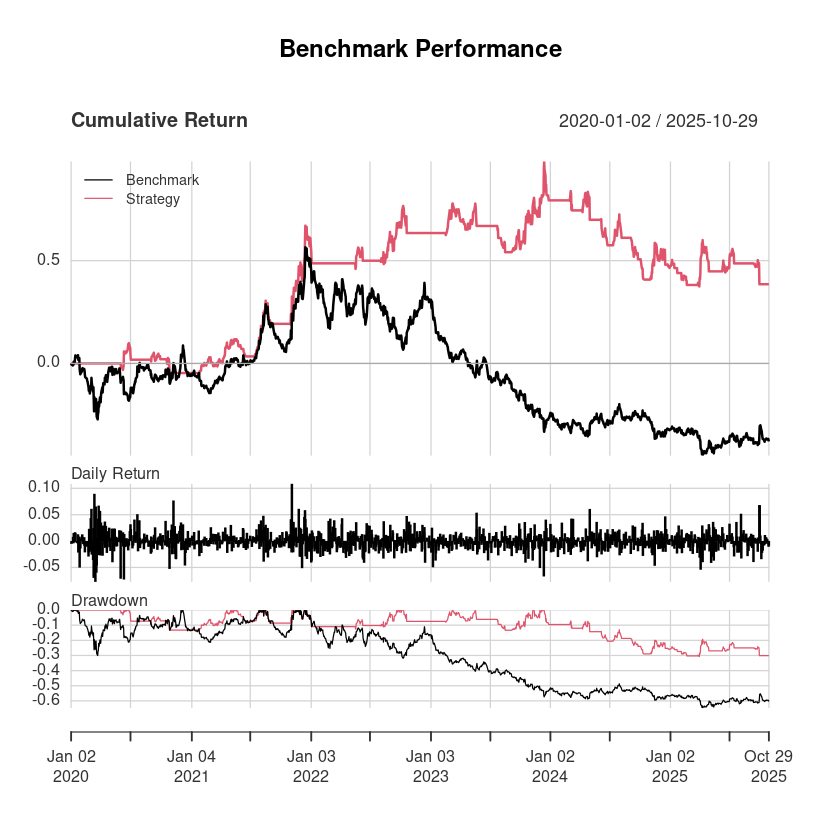

In [19]:
#| fig-cap: "BB Strategy Backtesting"
signals_bb  <- bb_strategy(pfe_data)

# Recall backtest function
source(file.path(getwd(), "../../strategies/bollinger_breakout.R"))

xts_prices  <- xts(signals_bb$prccd, order.by = signals_bb$datadate)
xts_signals <- xts(signals_bb$position, order.by = signals_bb$datadate)
bt <- backtest(xts_prices, xts_signals)

charts.PerformanceSummary(bt)

The `strategy_BB_breakout()` function, as we can see from the backtest results, outperforms the benchmark significantly during trending periods, capturing substantial price movements. However, it also experiences notable drawdowns during sideways markets, indicating vulnerability to false breakouts, particularly from early 2024 to mid-2025, with a maximum drawdown of approximately −30%. Compared to the benchmark, which suffers a drawdown exceeding −60%, the Bollinger Bands strategy still demonstrates improved risk management and solid return generation, ending with a cumulative return of around 40%.

The next step is to optimize the parameters. Further enhancements could involve integrating trend filters or volatility measures to reduce exposure during non-trending periods, thereby improving overall robustness and performance consistency. 


## Optimizing Bollinger Bands Parameters & Results
To optimize the Bollinger Bands parameters, I test a range of values for the BB window, BB standard deviation multiplier, and BB compression signal by implementing a loop function that iterates over all combinations of the specified parameter values.

In [20]:
bbperiod_candidates  <- c(7, 14, 20, 25, 30, 35, 48)
rsiperiod_candidates  <-  c(7, 14, 20, 25, 30, 35, 48)
bbstdev_candidates  <- c(1.2, 1.5, 1.8, 2, 2.2, 2.5, 3)
bbquantil_candidates  <- c(0.28, 0.33, 0.4, 0.5, 0.55, 0.6)

In [21]:
best_perf  <- -Inf
best_bp  <- NA
best_rp  <- NA
best_sd  <- NA
best_bq  <- NA

for (bp in bbperiod_candidates) {
  for (rp in rsiperiod_candidates) {
    for(sd in bbstdev_candidates) {
      for(bq in bbquantil_candidates) {

        
        signals  <- bb_strategy(pfe_data,
                                price_col = "prccd",
                                bb_n = bp,
                                k = sd,
                                rsi_n = rp,
                                rsi_long_thr = 53,
                                rsi_short_thr = 47,
                                bbw_quantile = bq)


        # Backtest process for each combination
        xts_prices  <- xts(signals$prccd, order.by = signals$datadate)
        xts_signals <- xts(signals$position, order.by = signals$datadate)
        bt <- backtest(xts_prices, xts_signals)

        # Calculated the performance for each pairs
        perf  <- prod(1 + bt$Strategy, na.rm = TRUE)

        # I compare the cumulative return with the previous best
        if (perf > best_perf) {
         best_perf <- perf
         best_bp  <- bp
         best_rp  <- rp
         best_sd  <- sd
         best_bq  <- bq


        }
      }
    }
  }
}


In [22]:
print(best_bp)
print(best_rp)
print(best_sd)
print(best_bq)

[1] 20
[1] 14
[1] 2.2
[1] 0.55


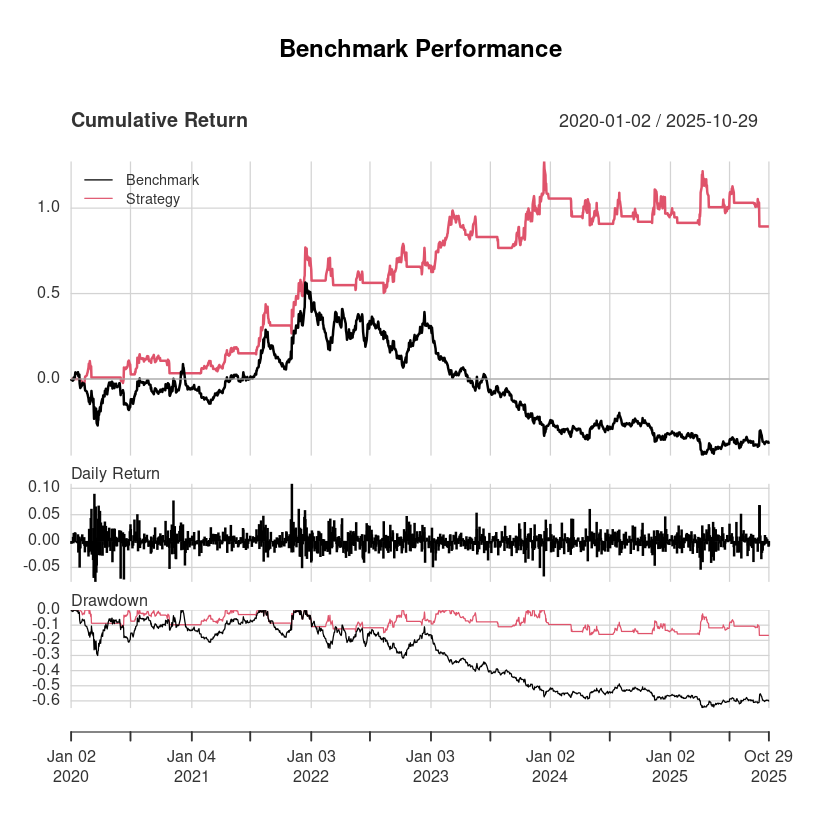

In [23]:
#| fig-cap: "BB Strategy Optimized Backtesting"
signals_opti  <-  bb_strategy(pfe_data,
                                price_col = "prccd",
                                bb_n = best_bp,
                                k = best_sd,
                                rsi_n = best_rp,
                                rsi_long_thr = 53,
                                rsi_short_thr = 47,
                                bbw_quantile = best_bq)

xts_prices  <- xts(signals_opti$prccd, order.by = signals_opti$datadate)
xts_signals <- xts(signals_opti$position, order.by = signals_opti$datadate)
bt <- backtest(xts_prices, xts_signals)

charts.PerformanceSummary(bt)

# Conclusion 

The analysis and backtesting of the Triple Moving Average and Bollinger Bands Breakout strategies on Pfizer (PFE) stock data from 2020 to 2025 demonstrate the effectiveness of trend-following approaches in capturing market movements while managing risk. The latter, even though it is not optimized yet, still shows promising results. The peculiar market conditions during this period, characterized by significant volatility and frequent trend shifts, provided a robust testing ground for these strategies. Therefore, the introduction of regime filters and confirmation indicators proved crucial in enhancing performance and reducing drawdowns. Future work could focus on further parameter optimization, integration of additional technical indicators, and testing across different market conditions and asset classes to validate the strategies’ robustness and adaptability.